<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Identifying west nile virus hotspots and its exacerbating factors
### Part1: Feature Engineering and Selection

This section will focus on engineering features for subsequent data analysis. As weather lag has already been generated already, the features generated here will be related to time, species, and location of traps. After which, preliminary analysis with Random Forest will be used to select a few combination of features to be used for modelling.

- Engineer features (e.g. temporal, species, weatherlag etc.) which will be required for modelling
- Perform preliminary analysis to select features to be used for modelling and tuning
- Save datasets for modelling and Kaggle test

# Contents

Preliminary Analysis and Selection of Different Weather Lags
- [Weather Lag Selection](#Preliminary-Analysis-and-Selection-of-Different-Weather-Lags)
- [Weather Feature Selection](#Weather-Feature-Selection)

Feature Engineering for temporal, species and location(trap) variables
- [Exploring Locations(Traps)](#Relationship-between-locations-(traps)-and-time-with-WNV-present)
- [Feature Engineering](#Feature-Engineering)

Preliminary Analysis and Selection of Best Combination of Features and Weather Lag
- [Model Feature Selection](#Model-Feature-Selection)

Merging datasets for analysis and Kaggle
- [Merging Datasets for Modelling](#Merging-Datasets-for-Modelling)
- [Merging Datasets for Kaggle Test](#Merging-Datasets-for-Kaggle-Test)

In [1]:
# Import Packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix, 
    plot_confusion_matrix,
    roc_auc_score,
    recall_score
)

# Preliminary Analysis and Selection of Different Weather Lags

Weather conditions will have an effect of WNV spread, as conditions such as wind will affect the mosquitos' mobility and precipitation will affect its availability of breeding grounds. However, it is intuitive that this effect is not immediate and will take several days to influence mosquito numbers. Here we will explore what is the best time interval (time lag) to model this effect.

In [2]:
# Read in datasets

lag0 = pd.read_csv(r'../data/weather_cleaned_lag0.csv')
lag2 = pd.read_csv(r'../data/weather_cleaned_lag2.csv')
lag3 = pd.read_csv(r'../data/weather_cleaned_lag3.csv')
lag5 = pd.read_csv(r'../data/weather_cleaned_lag5.csv')
lag7 = pd.read_csv(r'../data/weather_cleaned_lag7.csv')
lag14 = pd.read_csv(r'../data/weather_cleaned_lag14.csv')
lag21 = pd.read_csv(r'../data/weather_cleaned_lag21.csv')
lag28 = pd.read_csv(r'../data/weather_cleaned_lag28.csv')

In [3]:
lag2.columns

Index(['date', 'species', 'latitude', 'longitude', 'trap', 'nummosquitos',
       'wnvpresent', 'wnvcount', 'id', 'station', 'tavg', 'dewpoint',
       'codesum', 'preciptotal', 'stnpressure', 'sealevel', 'resultdir',
       'avgspeed', 'month', 'sunset', 'bcfg', 'br', 'dz', 'fg', 'fg+', 'fu',
       'hz', 'mifg', 'ra', 'sn', 'sq', 'ts', 'tsra', 'vcts', 'gr', 'vcfg'],
      dtype='object')

In [146]:
# Create function to perform classification of train data (Random Forest)
# and add scores to a table

def rf_weather_lag(df, lag_num, concat_df=None):
    
    df.drop(columns=['id'], axis=1, inplace=True)
    df = df.dropna()
    X = df[[col for col in df.columns if (df[col].dtypes !='O') & 
                      (col not in ['date','nummosquitos', 'wnvcount','wnvpresent',
                                   'station','species', 'month'])]]
    y = df['wnvpresent']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        stratify=y,
        random_state=42
    )
    
    ss = StandardScaler()
    
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators=100)
    
    train_acc = cross_val_score(
        rf,
        X_train,
        y_train,
        cv=5
    ).mean()
    
    test_acc = cross_val_score(
        rf,
        X_test,
        y_test,
        cv=5
    ).mean()
    
    rf.fit(X_train, y_train)
    
    forest_predictions = rf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, forest_predictions).ravel()
    
    sensitivity = recall_score(y_test, forest_predictions)

    specificity = (tn / (tn + fp))
    
    roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
    
    weather_dict = {
        'weather_lag': lag_num, 
        'train_acc': [round(train_acc * 100, 2)], 
        'test_acc': [round(test_acc * 100, 2)], 
        'sensitivity': [round(sensitivity * 100, 2)], 
        'specificity': [round(specificity * 100, 2)],
        'roc_auc_score': [round(roc_auc * 100, 2)]
    }
    
    new_df = pd.DataFrame(weather_dict)
    
    if isinstance(concat_df, pd.DataFrame) == True:
        final_df = pd.concat(
            objs=[concat_df, new_df],
            axis=0
        )
        final_df.reset_index(drop=True, inplace=True)
        return final_df
        
    else:    
        return new_df
    

In [147]:
# Perform analysis with different weather lags

weather_lag_df = rf_weather_lag(lag0, 0)
weather_lag_df = rf_weather_lag(lag2, 2, weather_lag_df)
weather_lag_df = rf_weather_lag(lag3, 3, weather_lag_df)
weather_lag_df = rf_weather_lag(lag5, 5, weather_lag_df)
weather_lag_df = rf_weather_lag(lag7, 7, weather_lag_df)
weather_lag_df = rf_weather_lag(lag14, 14, weather_lag_df)
weather_lag_df = rf_weather_lag(lag21, 21, weather_lag_df)
weather_lag_df = rf_weather_lag(lag28, 28, weather_lag_df)

In [148]:
# Print the metrics of the different models

weather_lag_df

,weather_lag,train_acc,test_acc,sensitivity,specificity,roc_auc_score
0,0,92.90,93.54,16.67,97.16,77.85
1,2,92.92,93.39,15.79,97.26,75.99
2,3,92.97,93.44,18.42,97.36,76.28
3,5,92.98,93.63,15.79,97.46,76.21
4,7,93.00,93.58,16.67,97.51,77.80
5,14,93.06,93.11,16.67,97.21,76.89
6,21,93.06,93.44,16.67,97.21,76.59
7,28,93.28,93.11,18.42,97.94,74.43


In [149]:
# Create function to perform classification of train data (Random Forest with oversampling)
# and add scores to a table

def rf_2_weather_lag(df, lag_num, concat_df=None):
    
    df.drop(columns=['id'], axis=1, inplace=True)
    df = df.dropna()
    X = df[[col for col in df.columns if (df[col].dtypes !='O') & 
                      (col not in ['date','nummosquitos', 'wnvcount','wnvpresent',
                                   'station','species', 'month'])]]
    y = df['wnvpresent']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        stratify=y,
        random_state=42
    )
    
    ss = StandardScaler()
    
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    
    rf =  RandomForestClassifier(
        n_estimators=1500,
        ccp_alpha=0,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced_subsample')
    
    train_acc = cross_val_score(
        rf,
        X_train,
        y_train,
        cv=5
    ).mean()
    
    test_acc = cross_val_score(
        rf,
        X_test,
        y_test,
        cv=5
    ).mean()
    
    rf.fit(X_train, y_train)
    
    forest_predictions = rf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, forest_predictions).ravel()
    
    sensitivity = recall_score(y_test, forest_predictions)

    specificity = (tn / (tn + fp))
    
    roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
    
    weather_dict = {
        'weather_lag': lag_num, 
        'train_acc': [round(train_acc * 100, 2)], 
        'test_acc': [round(test_acc * 100, 2)], 
        'sensitivity': [round(sensitivity * 100, 2)], 
        'specificity': [round(specificity * 100, 2)],
        'roc_auc_score': [round(roc_auc * 100, 2)]
    }
    
    new_df = pd.DataFrame(weather_dict)
    
    if isinstance(concat_df, pd.DataFrame) == True:
        final_df = pd.concat(
            objs=[concat_df, new_df],
            axis=0
        )
        final_df.reset_index(drop=True, inplace=True)
        return final_df
        
    else:    
        return new_df
    

In [151]:
# Perform analysis with different weather lags

weather_lag_df2 = rf_2_weather_lag(lag0, 0)
weather_lag_df2 = rf_2_weather_lag(lag2, 2, weather_lag_df2)
weather_lag_df2 = rf_2_weather_lag(lag3, 3, weather_lag_df2)
weather_lag_df2 = rf_2_weather_lag(lag5, 5, weather_lag_df2)
weather_lag_df2 = rf_2_weather_lag(lag7, 7, weather_lag_df2)
weather_lag_df2 = rf_2_weather_lag(lag14, 14, weather_lag_df2)
weather_lag_df2 = rf_2_weather_lag(lag21, 21, weather_lag_df2)
weather_lag_df2 = rf_2_weather_lag(lag28, 28, weather_lag_df2)

In [152]:
# Print the metrics of the different models

weather_lag_df2

,weather_lag,train_acc,test_acc,sensitivity,specificity,roc_auc_score
0,0,79.63,88.82,71.05,81.40,84.84
1,2,81.06,89.01,69.30,81.95,84.90
2,3,80.46,89.52,71.93,81.50,84.92
3,5,81.21,88.77,71.93,83.44,85.20
4,7,80.36,89.81,72.81,81.90,85.52
5,14,82.06,88.49,71.05,83.44,85.45
6,21,80.90,88.35,73.68,82.04,84.65
7,28,81.49,89.45,60.53,82.62,82.56


**Recommended weather lag**

Based on the randomforest model, 7day and 21day lag appears to be the best

# Weather Feature Selection
Here we will do a rough first cut of the weather features. Weather features that have VERY LOW features importance according to the Random Forest model will be removed.

In [4]:
# Fitting a Random Forest Model with lag 7 weather variables

lag7_train = lag7.drop(columns=['id'], axis=1)
lag7_train = lag7_train.dropna()
X = lag7_train[[col for col in lag7_train.columns if (lag7_train[col].dtypes !='O') & 
                      (col not in ['date','nummosquitos', 'wnvcount','wnvpresent',
                                   'station','species', 'month'])]]
y = lag7_train['wnvpresent']
    
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        stratify=y,
        random_state=42
    )
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [5]:
rfs_hyperparam_bal =  RandomForestClassifier(
        n_estimators=1500,
        ccp_alpha=0,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced_subsample')

# Fitting X_train_sc and y_train on RandomForestClassifier object defined above.

rfs_hyperparam_bal.fit(X_train, y_train)


RandomForestClassifier(ccp_alpha=0, class_weight='balanced_subsample',
                       max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=1500, random_state=42)

In [6]:
# create function to plot feature importance

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,15))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

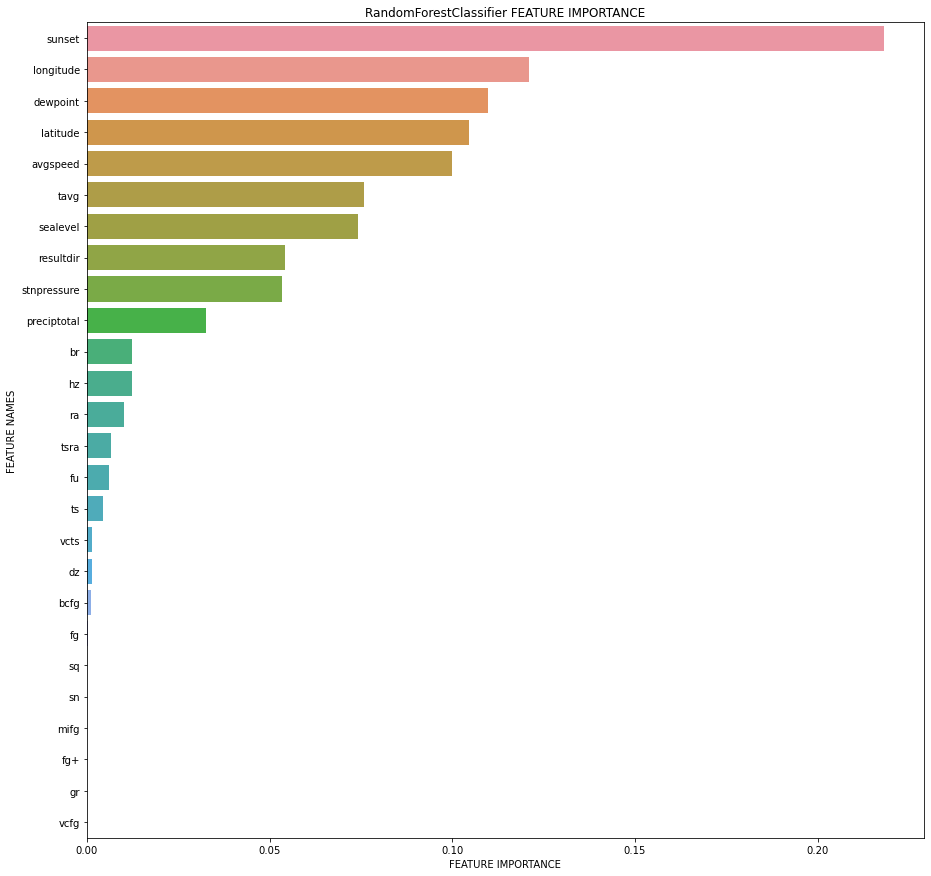

In [7]:
plot_feature_importance(rfs_hyperparam_bal.feature_importances_,X.columns,'RandomForestClassifier')

In [ ]:
# Fitting a Random Forest Model with lag 21 weather variables

lag21_train = lag21.drop(columns=['id'], axis=1)
lag21_train = lag21_train.dropna()
X = lag21_train[[col for col in lag21_train.columns if (lag21_train[col].dtypes !='O') & 
                      (col not in ['date','nummosquitos', 'wnvcount','wnvpresent',
                                   'station','species', 'month'])]]
y = lag21_train['wnvpresent']
    
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        stratify=y,
        random_state=42
    )
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
rfs_hyperparam_bal =  RandomForestClassifier(
        n_estimators=1500,
        ccp_alpha=0,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced_subsample')

# Fitting X_train_sc and y_train on RandomForestClassifier object defined above.

rfs_hyperparam_bal.fit(X_train, y_train)

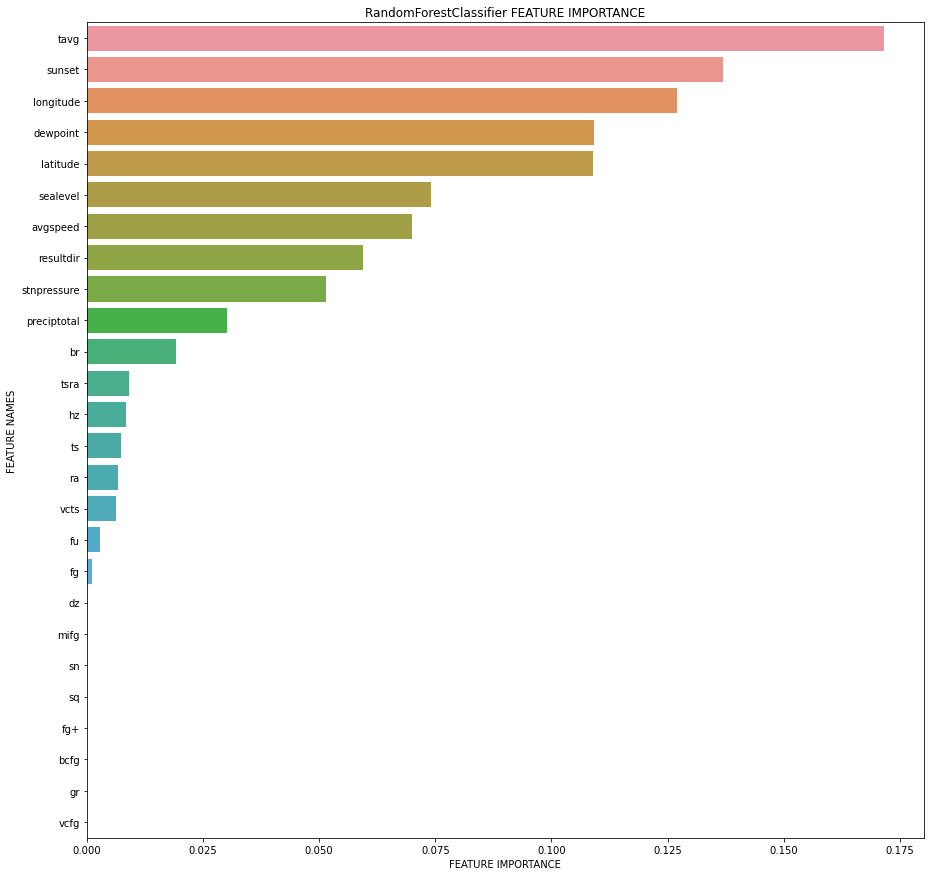

In [160]:
plot_feature_importance(rfs_hyperparam_bal.feature_importances_,X.columns,'RandomForestClassifier')

**Preliminary feature importance assessment**<br/>
Features with VERY low feature importance appear to be very similar in lag7 and lag21. To remove the bottom 9 variables which are common across both lags.

In [3]:
# save to csv

#lag7_p = lag7.drop(['vcfg', 'gr', 'fg+', 'mifg', 'sn', 'sq', 'fg', 'bcfg', 'dz'], axis=1)
lag14_p = lag7.drop(['vcfg', 'gr', 'fg+', 'mifg', 'sn', 'sq', 'fg', 'bcfg', 'dz'], axis=1)
#lag21_p = lag21.drop(['vcfg', 'gr', 'fg+', 'mifg', 'sn', 'sq', 'fg', 'bcfg', 'dz'], axis=1)

#lag7_p.to_csv('../data/lag7_p.csv', index=False)
lag14_p.to_csv('../data/lag14_p.csv', index=False)
#lag21_p.to_csv('../data/lag21_p.csv', index=False)

# Relationship between locations (traps) and time with WNV present

In an earlier exploratory data analysis, we have seen that the prevalence of the West Nile Virus varies greatly across the years and within the weeks/months within each year. Here, we will further explore if the locations (traps) vary widely as well.

If the same traps consistently appear in each year. It is likely that the WNV hotspots are consistent.
If the there are groups of traps that appear is certain years (or groups of years) but not others, there is a chance that there are some interactions between location (traps) and time.

In [6]:
# import data

merge_df = pd.read_csv('../data/merged_train.csv')

# create time related features

merge_df['date']=pd.to_datetime(merge_df['date'])
merge_df['year'] = merge_df['date'].dt.year
merge_df['month'] = merge_df['date'].dt.month
merge_df['week'] = merge_df['date'].dt.isocalendar().week

# subset required columns and rows
betw_year = merge_df[['trap', 'year', 'wnvpresent', 'wnvcount']]
betw_year = betw_year.loc[betw_year['wnvpresent']>0,:]           # only rows where wnv is present

# Collapse by trap and year
betw_year = betw_year.groupby(['trap', 'year'], as_index=False)[['wnvpresent', 'wnvcount']]\
.sum().sort_values(['year','wnvpresent'], ascending=False)

In [7]:
# Is there a consistent wave of WNV in each year?

betw_year.groupby('year')[['wnvpresent']].sum()

,wnvpresent
year,
2007,189.0
2009,19.0
2011,50.0
2013,199.0


**Is there a consistent wave of WNV in each year?**<br/>
No, mosquitos thrive in some years but not others. This is probably due to favourable conditions in 2007 and 2013 but not in 2009 and 2011. Unfortunately, as it is not able to objectively determine the cause and effect of this. However, if it is related to weather conditions, our weather variables will account for this variation.

In [8]:
# Are mosquitos always found in the same location? 
# IE MOSQUITOS THRIVE IN SPECIFIC LOCATIONS Reardless of year on year changes

betw_year['years_wnvp'] = betw_year['wnvpresent'].map(lambda x: 1 if x >0 else 0)

betw_year.groupby(['trap'])['wnvpresent', 'years_wnvp'].sum()\
.sort_values('years_wnvp', ascending=False)[['years_wnvp']].value_counts()


C:\Users\User\AppData\Local\Temp/ipykernel_12368/1500054444.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  betw_year.groupby(['trap'])['wnvpresent', 'years_wnvp'].sum()\


years_wnvp
1             51
2             26
3             16
4              4
dtype: int64

**Are mosquitos always found in the same location?**<br/>
Not exactly. Only 4 locations have WNV present consistently across the 4 years. Even if we use the year with lowest number of WNV found in the traps (2009) the 4 traps only account for 4/19 of them. This means that there are very few hotspots that have WNV independent of the year (or annual weather conditions).

In [9]:
# Are the hotspots in specific group of years?

inter_year = betw_year.pivot(index='trap', columns='year', values=['wnvpresent'])
inter_year.fillna(0, inplace=True)

In [10]:
# positive traps in 2007
ptrap_2007 = betw_year.loc[betw_year['year']==2007, 'trap']
ptrap_2009 = betw_year.loc[betw_year['year']==2009, 'trap']
ptrap_2011 = betw_year.loc[betw_year['year']==2011, 'trap']
ptrap_2013 = betw_year.loc[betw_year['year']==2013, 'trap']

ptrap_2007 = set(ptrap_2007)
ptrap_2009 = set(ptrap_2009)
ptrap_2011 = set(ptrap_2011)
ptrap_2013 = set(ptrap_2013)

In [9]:
ptrap_2007.intersection(ptrap_2009, ptrap_2011, ptrap_2013)

{'T002', 'T090', 'T095', 'T158'}

In [10]:
ptrap_2007_2013 = ptrap_2007.intersection(ptrap_2013)
len(ptrap_2007_2013)

33

**Are the hotspots in specific group of years?**
We previously saw that there are onyl 4 traps that found WNV present mosquitos in all 4 years. Here we additionally find that there are groups of traps that have WNV in a subset of years. For example, that are 33 traps with WNV present in year 2007 and 2013. This suggests that some hotspots on appear in certain years, possibly due to similar conditions in those years.

### Remarks

In the exploration above, we have seen that there is small number of traps that will have WNV present mosquitos every year (ie. locations that are independent across time). However, there are also many traps that are only "hotspots" in specific years (ie. an interation of location and time and/or weather conditions).

**Modelling implications**<br/>
To account for this, we will include traps in our model which have both a high overall WNVpresent across years, as well as within years. As we expect the interaction effects to be very complex, it will be unfeasible to manyally create these interaction terms. Fortunately, models such as Random Forest, will naturally account for these effects.

As such, we will include Random Forest as one of the models to be explored later on. Additionally we will also expect Random Forest to perform better than a model such as Logistic Regression which does not explicitly account for such interactions.

## Selecting location (traps) to be included for analysis

To avoid including ALL traps in the model and risk overfitting, we will include only a subset of traps in the model. As explained earlier, these traps will show a high WNV count across years OR within year). (ie. a hotpost across years or wihtin each year.<br/>
1. WNV ACROSS YEARS
   - WNV in the same trap ACROSS years
   - High counts of WNV ACROSS years
2. High count WITHIN each year

Across years: Appear in 
    at least 3 of 4 years (20 traps) ay_3of4
    at least 2 of 4 years (46 traps) ay_2of4

Across years: wnvpresent 
    > wnvpresent 8 times (17 traps) ay_8nabov
    > wnvpresent 6 times (25 traps) ay_6nabov    

Within years: wnvpresent at least 4
2007 (19 traps) wy_2007_4nabv
2009 (0 traps)  0
2011 (3 traps)  wy_2011_4nabv
2013 (22 traps) wy_2013_4nabv


Within years: wnvpresent at least 3
2007 (27 traps) wy_2007_3nabv
2009 (0 traps)  0
2011 (4 traps)  wy_2011_3nabv
2013 (33 traps) wy_2013_3nabv

### WNV in the same trap ACROSS years

To create 2 groups of traps
1) Traps with WNV present in at least 3 of 4 years<br/>
2) Traps with WNV present in at least 2 of 4 years

In [11]:
# Create variable which shows how many ears the trap has positive WNV

ay = betw_year.groupby(['trap'])['wnvpresent', 'years_wnvp'].sum()\
.sort_values('years_wnvp', ascending=False)
ay[:5]

C:\Users\User\AppData\Local\Temp/ipykernel_12368/3925836779.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ay = betw_year.groupby(['trap'])['wnvpresent', 'years_wnvp'].sum()\


,wnvpresent,years_wnvp
trap,,
T002,15.0,4
T090,7.0,4
T095,5.0,4
T158,5.0,4
T028,9.0,3


In [12]:
# Traps with WNV present in at least 3 of 4 years (ay_3of4)

ay_3of4 = ay.loc[ay['years_wnvp']>2,:].index
ay_3of4

Index(['T002', 'T090', 'T095', 'T158', 'T028', 'T003', 'T114', 'T115', 'T151',
       'T039', 'T031', 'T073', 'T011', 'T225', 'T900', 'T013', 'T230', 'T008',
       'T221', 'T009'],
      dtype='object', name='trap')

In [13]:
# Traps with WNV present in at least 2 of 4 years (ay_2of4)

ay_2of4 = ay.loc[ay['years_wnvp']>1,:].index
ay_2of4

Index(['T002', 'T090', 'T095', 'T158', 'T028', 'T003', 'T114', 'T115', 'T151',
       'T039', 'T031', 'T073', 'T011', 'T225', 'T900', 'T013', 'T230', 'T008',
       'T221', 'T009', 'T102', 'T081', 'T082', 'T083', 'T089', 'T094', 'T220',
       'T128', 'T135', 'T228', 'T152', 'T080', 'T159', 'T223', 'T160', 'T155',
       'T903', 'T035', 'T065', 'T048', 'T027', 'T061', 'T012', 'T063', 'T066',
       'T033'],
      dtype='object', name='trap')

### High counts of WNV ACROSS years

To create 2 groups of traps
1) Traps with WNV present found at least 8 times<br/>
2) Traps with WNV present found at least 6 times

In [14]:
ay_c = betw_year.groupby(['trap'])['wnvpresent',].sum()\
.sort_values('wnvpresent', ascending=False)

ay_c.head()

,wnvpresent
trap,
T900,29.0
T002,15.0
T115,15.0
T003,14.0
T225,11.0


In [15]:
# Traps with WNV present found at lest 8 times (ay_8nabov)

ay_8nabov = ay_c.loc[ay['wnvpresent']>7,:].index
ay_8nabov

Index(['T900', 'T002', 'T115', 'T003', 'T225', 'T011', 'T013', 'T028', 'T223',
       'T138', 'T114', 'T903', 'T008', 'T009', 'T061', 'T082', 'T135'],
      dtype='object', name='trap')

In [16]:
# Traps with WNV present found at lest 8 times (ay_6nabov)

ay_6nabov = ay_c.loc[ay['wnvpresent']>5,:].index
ay_6nabov

Index(['T900', 'T002', 'T115', 'T003', 'T225', 'T011', 'T013', 'T028', 'T223',
       'T138', 'T114', 'T903', 'T008', 'T009', 'T061', 'T082', 'T135', 'T027',
       'T030', 'T090', 'T235', 'T086', 'T230', 'T221', 'T128', 'T066', 'T151',
       'T155', 'T228', 'T233'],
      dtype='object', name='trap')

### High count WITHIN each year

To create 2 groups of traps

1) Traps with WNV present found at least 4 times within each year<br/>
2) Traps with WNV present found at least 3 times within each year

In [24]:
# Get list of traps within each year

wy_2007_4nabv = betw_year.loc[(betw_year['year']==2007) & (betw_year['wnvcount']>3), 'trap']
wy_2009_4nabv = betw_year.loc[(betw_year['year']==2009) & (betw_year['wnvcount']>3), 'trap']
wy_2011_4nabv = betw_year.loc[(betw_year['year']==2011) & (betw_year['wnvcount']>3), 'trap']
wy_2013_4nabv = betw_year.loc[(betw_year['year']==2013) & (betw_year['wnvcount']>3), 'trap']

# Save list of traps within each year into ONE list 
wy_4nabv = list(wy_2007_4nabv).copy()
wy_4nabv.extend(wy_2009_4nabv)
wy_4nabv.extend(wy_2011_4nabv)
wy_4nabv.extend(wy_2013_4nabv)

In [22]:
# Get list of traps within each year

wy_2007_3nabv = betw_year.loc[(betw_year['year']==2007) & (betw_year['wnvcount']>2), 'trap']
wy_2009_3nabv = betw_year.loc[(betw_year['year']==2009) & (betw_year['wnvcount']>2), 'trap']
wy_2011_3nabv = betw_year.loc[(betw_year['year']==2011) & (betw_year['wnvcount']>2), 'trap']
wy_2013_3nabv = betw_year.loc[(betw_year['year']==2013) & (betw_year['wnvcount']>2), 'trap']

# Save list of traps within each year into ONE list
wy_3nabv = list(wy_2007_3nabv).copy()
wy_3nabv.extend(wy_2009_3nabv)
wy_3nabv.extend(wy_2011_3nabv)
wy_3nabv.extend(wy_2013_3nabv)

### Different groups of traps
We have engineered 3 different groups of traps, each with increaing number. 

In [38]:
group_1 = list(ay_8nabov)
group_1.extend(ay_3of4)
group_1.extend(wy_4nabv)
group_1 = list(set(group_1))
len(group_1)

46

In [36]:
group_2 = list(ay_6nabov)
group_2.extend(ay_3of4)
group_2.extend(wy_3nabv)
group_2 = list(set(group_2))
len(group_2)

57

In [37]:
group_3 = list(ay_6nabov)
group_3.extend(ay_2of4)
group_3.extend(wy_3nabv)
group_3 = list(set(group_3))
len(group_3)

68

# Feature Engineering

So far, we have seen that certain species, weeks and locations (traps) are likely to have more WNV present. Feature engineering will be performed in this section to ensure these effects are accounted for (dummy coding the features).

In [22]:
# read in train data
train_merged = pd.read_csv('../data/merged_train.csv')

In [23]:
train_merged.columns

Index(['date', 'species', 'latitude', 'longitude', 'trap', 'nummosquitos',
       'wnvpresent', 'wnvcount', 'station', 'tmax', 'tmin', 'tavg', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'codesum', 'preciptotal', 'stnpressure',
       'sealevel', 'resultspeed', 'resultdir', 'avgspeed', 'month', 'sunrise',
       'sunset', 'bcfg', 'br', 'dz', 'fg', 'fg+', 'fu', 'hz', 'mifg', 'ra',
       'sn', 'sq', 'ts', 'tsra', 'vcts', 'gr', 'vcfg', 'sprayed'],
      dtype='object')

In [24]:
# extract columns required for enginnering (dummy coding)

train_fe = train_merged[['date', 'species', 'latitude',
                         'longitude', 'trap', 'wnvpresent']].copy()

**Dummy coding for species**

In [26]:
train_fe['culex_pipiens/restuans'] = train_fe['species'].map(lambda x: 1 if x == 'CULEX PIPIENS/RESTUANS' else 0)
train_fe['culex_pipiens'] = train_fe['species'].map(lambda x: 1 if x == 'CULEX PIPIENS' else 0)
train_fe['culex_restuans'] = train_fe['species'].map(lambda x: 1 if x == 'CULEX RESTUANS' else 0)

**Dummy coding for week**

In [27]:
# create week variable
train_fe['date'] = pd.to_datetime(train_fe['date'])
train_fe['week'] = train_fe['date'].dt.isocalendar().week

In [28]:
# Dummy coding for week

train_fe.groupby('week')['wnvpresent'].sum()

week
22      0.0
23      0.0
24      0.0
25      0.0
26      1.0
27      0.0
28      7.0
29     15.0
30     16.0
31     39.0
32     54.0
33     66.0
34    107.0
35     47.0
36     44.0
37     34.0
38     19.0
39      6.0
40      2.0
41      0.0
Name: wnvpresent, dtype: float64

In [29]:
# Only select weeks that have more than 2 counts

train_fe = pd.get_dummies(train_fe, columns=['week'], drop_first=False)

train_fe.drop(columns=['week_22', 'week_23', 'week_24', 'week_25', 
                            'week_26', 'week_27', 'week_40', 'week_41'],
                  axis=1,
                  inplace=True)
train_fe.shape

(8475, 21)

In [30]:
# extract col_names

col_wo_trap = list(train_fe.columns)
col_wo_trap


['date',
 'species',
 'latitude',
 'longitude',
 'trap',
 'wnvpresent',
 'culex_pipiens/restuans',
 'culex_pipiens',
 'culex_restuans',
 'week_28',
 'week_29',
 'week_30',
 'week_31',
 'week_32',
 'week_33',
 'week_34',
 'week_35',
 'week_36',
 'week_37',
 'week_38',
 'week_39']

**Dummy coding for traps**

In [31]:
# Create dataframe of ALL trap dummies

train_fe['trap_d'] = train_fe['trap']          # duplicate trap col as
                                               # we need to merge on it later
train_fe = pd.get_dummies(train_fe, columns=['trap'])         # get dummies
train_fe.rename(columns = {'trap_d':'trap'}, inplace = True) #rename to trap


In [39]:
# Create a list of variables for each group
# Create dataset for each group with newly added species, week, trap variables

In [33]:
# Creating dataframe with Group 1 trap features

g1 = ['trap_' + x for x in group_1] # Create colnames of traps features for only Group 1 traps
g1_others = col_wo_trap.copy()      # Create colnames of all features EXCEPT traps
g1_others.extend(g1)                # Combine colnames into one list
train_fe_g1 = train_fe[g1_others]   # Extract features with group 1 traps into a dataframe
train_fe_g1.shape

(8475, 67)

In [34]:
# Creating dataframe with Group 2 trap features

g2 = ['trap_' + x for x in group_2] # Create colnames of traps features for only Group 2 traps
g2_others = col_wo_trap.copy()      # Create colnames of all features EXCEPT traps
g2_others.extend(g2)                # Combine colnames into one list
train_fe_g2 = train_fe[g2_others]   # Extract features with group 2 traps into a dataframe
train_fe_g2.shape

(8475, 78)

In [35]:
# Creating dataframe with Group 3 trap features

g3 = ['trap_' + x for x in group_3] # Create colnames of traps features for only Group 2 traps
g3_others = col_wo_trap.copy()      # Create colnames of all features EXCEPT traps
g3_others.extend(g3)                # Combine colnames into one list
train_fe_g3 = train_fe[g3_others]   # Extract features with group 3 traps into a dataframe
train_fe_g3.shape

(8475, 89)

In [36]:
train_fe_g1.columns

Index(['date', 'species', 'latitude', 'longitude', 'trap', 'wnvpresent',
       'culex_pipiens/restuans', 'culex_pipiens', 'culex_restuans', 'week_28',
       'week_29', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34',
       'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'trap_T223',
       'trap_T225', 'trap_T096', 'trap_T054', 'trap_T031', 'trap_T013',
       'trap_T128', 'trap_T095', 'trap_T903', 'trap_T151', 'trap_T086',
       'trap_T231', 'trap_T235', 'trap_T147', 'trap_T135', 'trap_T039',
       'trap_T066', 'trap_T003', 'trap_T011', 'trap_T015', 'trap_T115',
       'trap_T027', 'trap_T227', 'trap_T030', 'trap_T226', 'trap_T158',
       'trap_T230', 'trap_T016', 'trap_T900', 'trap_T008', 'trap_T061',
       'trap_T073', 'trap_T082', 'trap_T221', 'trap_T103', 'trap_T028',
       'trap_T006', 'trap_T138', 'trap_T114', 'trap_T002', 'trap_T233',
       'trap_T014', 'trap_T143', 'trap_T228', 'trap_T009', 'trap_T090'],
      dtype='object')

In [90]:
# Save groups with custom week, species and trap to csv

train_fe_g1.to_csv('../data/train_fe_g1.csv', index=False)
train_fe_g2.to_csv('../data/train_fe_g2.csv', index=False)
train_fe_g3.to_csv('../data/train_fe_g3.csv', index=False)


# Merging Datasets for Modelling
Merge New Features with Weather Lag Dataset

In [3]:
# import datasets

lag7_p = pd.read_csv(r'../data/lag7_p.csv')
lag14_p = pd.read_csv(r'../data/lag7_p.csv')
lag21_p = pd.read_csv(r'../data/lag21_p.csv')


train_g1 = pd.read_csv(r'../data/train_fe_g1.csv')
train_g2 = pd.read_csv(r'../data/train_fe_g2.csv')
train_g3 = pd.read_csv(r'../data/train_fe_g3.csv')

**Lag 7 Weather Features**

In [4]:
# lag 7 days Weather with Group 1 Features

lag7_g1 = train_g1.merge(lag7_p, how='left',
                    on=['date', 'species', 'latitude',
                        'longitude', 'wnvpresent', 'trap'],
                   )
print(lag7_g1.shape)

lag7_g1 = lag7_g1.drop(columns=['trap', 'species', 'month', 
                                'latitude', 'longitude','nummosquitos',
                                'wnvcount', 'station', 'codesum'], axis=1)
print(lag7_g1.shape)

(8475, 88)
(8475, 79)


In [43]:
# lag 7 days Weather with Group 2 Features

lag7_g2 = train_g2.merge(lag7_p, how='left',
                    on=['date', 'species', 'latitude',
                        'longitude', 'wnvpresent', 'trap'],
                   )
print(lag7_g2.shape)

lag7_g2 = lag7_g2.drop(columns=['trap', 'species', 'month', 
                                'latitude', 'longitude','nummosquitos',
                                'wnvcount', 'station', 'codesum'], axis=1)
print(lag7_g2.shape)

(8475, 99)

In [45]:
# lag 7 days Weather with Group 3 Features

lag7_g3 = train_g3.merge(lag7_p, how='left',
                    on=['date', 'species', 'latitude',
                        'longitude', 'wnvpresent', 'trap'],
                   )
print(lag7_g3.shape)

lag7_g3 = lag7_g3.drop(columns=['trap', 'species', 'month', 
                                'latitude', 'longitude','nummosquitos',
                                'wnvcount', 'station', 'codesum'], axis=1)
print(lag7_g3.shape)

(8475, 110)

**Lag 14 Weather Features**

In [47]:
# lag 14 days Weather with Group 1 Features

lag14_g1 = train_g1.merge(lag14_p, how='left',
                    on=['date', 'species', 'latitude',
                        'longitude', 'wnvpresent', 'trap'],
                   )
print(lag14_g1.shape)

lag14_g1 = lag14_g1.drop(columns=['trap', 'species', 'month', 
                                'latitude', 'longitude','nummosquitos',
                                'wnvcount', 'station', 'codesum'], axis=1)
print(lag14_g1.shape)

(8475, 88)

In [49]:
# lag 14 days Weather with Group 2 Features

lag14_g2 = train_g2.merge(lag14_p, how='left',
                    on=['date', 'species', 'latitude',
                        'longitude', 'wnvpresent', 'trap'],
                   )
print(lag14_g2.shape)

lag14_g2 = lag14_g2.drop(columns=['trap', 'species', 'month', 
                                'latitude', 'longitude','nummosquitos',
                                'wnvcount', 'station', 'codesum'], axis=1)
print(lag14_g2.shape)

(8475, 99)

In [51]:
# lag 14 days Weather with Group 3 Features

lag14_g3 = train_g3.merge(lag14_p, how='left',
                    on=['date', 'species', 'latitude',
                        'longitude', 'wnvpresent', 'trap'],
                   )
print(lag14_g3.shape)

lag14_g3 = lag14_g3.drop(columns=['trap', 'species', 'month', 
                                'latitude', 'longitude','nummosquitos',
                                'wnvcount', 'station', 'codesum'], axis=1)
print(lag14_g3.shape)

(8475, 110)

**Lag 21 Weather Features**

In [53]:
# lag 21 days Weather with Group 1 Features

lag21_g1 = train_g1.merge(lag21_p, how='left',
                    on=['date', 'species', 'latitude',
                        'longitude', 'wnvpresent', 'trap'],
                   )
print(lag21_g1.shape)

lag21_g1 = lag21_g1.drop(columns=['trap', 'species', 'month', 
                                'latitude', 'longitude','nummosquitos',
                                'wnvcount', 'station', 'codesum'], axis=1)
print(lag21_g1.shape)

(8475, 88)

In [56]:
# lag 21 days Weather with Group 2 Features

lag21_g2 = train_g2.merge(lag21_p, how='left',
                    on=['date', 'species', 'latitude',
                        'longitude', 'wnvpresent', 'trap'],
                   )
print(lag21_g2.shape)

lag21_g2 = lag21_g2.drop(columns=['trap', 'species', 'month', 
                                'latitude', 'longitude','nummosquitos',
                                'wnvcount', 'station', 'codesum'], axis=1)
print(lag21_g2.shape)

(8475, 99)

In [58]:
# lag 21 days Weather with Group 3 Features

lag21_g3 = train_g3.merge(lag21_p, how='left',
                    on=['date', 'species', 'latitude',
                        'longitude', 'wnvpresent', 'trap'],
                   )
print(lag21_g3.shape)

lag21_g3 = lag21_g3.drop(columns=['trap', 'species', 'month', 
                                'latitude', 'longitude','nummosquitos',
                                'wnvcount', 'station', 'codesum'], axis=1)
print(lag21_g3.shape)

(8475, 110)

# Model Feature Selection
To find the best few combinations of weather lag and feature groups.

In [67]:
def rf_lag_group(df, lag_num, grp_num, concat_df=None):
    
    df.drop(columns=['id'], axis=1, inplace=True)
    df = df.dropna()
    
    X = df.drop(columns=['wnvpresent', 'date'], axis=1)
    y = df['wnvpresent']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        stratify=y,
        random_state=42
    )
    
    ss = StandardScaler()
    
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    
    rf =  RandomForestClassifier(
        n_estimators=1500,
        ccp_alpha=0,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced_subsample')
    
    train_acc = cross_val_score(
        rf,
        X_train,
        y_train,
        cv=5
    ).mean()
    
    test_acc = cross_val_score(
        rf,
        X_test,
        y_test,
        cv=5
    ).mean()
    
    rf.fit(X_train, y_train)
    
    forest_predictions = rf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, forest_predictions).ravel()
    
    sensitivity = recall_score(y_test, forest_predictions)

    specificity = (tn / (tn + fp))
    
    roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
    
    weather_dict = {
        'feature_grp': grp_num,
        'weather_lag': lag_num, 
        'train_acc': [round(train_acc * 100, 2)], 
        'test_acc': [round(test_acc * 100, 2)], 
        'sensitivity': [round(sensitivity * 100, 2)], 
        'specificity': [round(specificity * 100, 2)],
        'roc_auc_score': [round(roc_auc * 100, 2)]
    }
    
    new_df = pd.DataFrame(weather_dict)
    
    if isinstance(concat_df, pd.DataFrame) == True:
        final_df = pd.concat(
            objs=[concat_df, new_df],
            axis=0
        )
        final_df.reset_index(drop=True, inplace=True)
        return final_df
        
    else:    
        return new_df
    

In [68]:
lag_group_train = rf_lag_group(lag7_g1, 7, grp_num='g1', concat_df=None)
lag_group_train = rf_lag_group(lag7_g2, 7, grp_num='g2', concat_df=lag_group_train)
lag_group_train = rf_lag_group(lag7_g3, 7, grp_num='g3', concat_df=lag_group_train)
lag_group_train = rf_lag_group(lag14_g1, 14, grp_num='g1', concat_df=lag_group_train)
lag_group_train = rf_lag_group(lag14_g2, 14, grp_num='g2', concat_df=lag_group_train)
lag_group_train = rf_lag_group(lag14_g3, 14, grp_num='g3', concat_df=lag_group_train)
lag_group_train = rf_lag_group(lag21_g1, 21, grp_num='g1', concat_df=lag_group_train)
lag_group_train = rf_lag_group(lag21_g2, 21, grp_num='g2', concat_df=lag_group_train)
lag_group_train = rf_lag_group(lag21_g3, 21, grp_num='g3', concat_df=lag_group_train)


In [69]:
lag_group_train

,feature_grp,weather_lag,train_acc,test_acc,sensitivity,specificity,roc_auc_score
0,g1,7,77.09,83.25,74.56,75.06,82.75
1,g2,7,77.00,83.25,74.56,74.76,82.73
2,g3,7,76.68,82.96,74.56,74.66,82.64
3,g1,14,77.09,83.25,74.56,75.06,82.75
4,g2,14,77.00,83.25,74.56,74.76,82.73
5,g3,14,76.68,82.96,74.56,74.66,82.64
6,g1,21,76.81,81.93,76.32,75.11,82.77
7,g2,21,76.73,82.07,77.19,74.56,82.78
8,g3,21,76.57,81.69,77.19,74.26,82.59


In [106]:
lag_group_train # this calculation was performed with stratify year and wnvpresent

,feature_grp,weather_lag,train_acc,test_acc,sensitivity,specificity,roc_auc_score
0,g1,7,75.82,81.60,75.44,72.02,81.46
1,g2,7,75.96,81.50,75.44,71.62,81.54
2,g3,7,75.76,81.17,75.44,71.82,81.48
3,g1,21,78.16,80.27,73.68,75.16,82.01
4,g2,21,78.10,80.46,71.93,75.31,81.95
5,g3,21,77.72,79.71,73.68,75.11,81.73


In [ ]:
lag_group_train

In [7]:
lag7_g1[['trap_T003']]

,trap_T003
0,0
1,0
2,0
3,0
4,0
...,...
8470,0
8471,0
8472,0
8473,0


In [8]:
# save to csv

lag7_g1.to_csv('../data/lag7_g1.csv', index=False)
#lag7_g2.to_csv('../data/lag7_g2.csv', index=False)
#lag7_g3.to_csv('../data/lag7_g3.csv', index=False)

#lag7_g1.to_csv('../data/lag14_g1.csv', index=False)
#lag14_g2.to_csv('../data/lag14_g2.csv', index=False)
#lag14_g3.to_csv('../data/lag14_g3.csv', index=False)

#lag21_g1.to_csv('../data/lag21_g1.csv', index=False)
#lag21_g2.to_csv('../data/lag21_g2.csv', index=False)
#lag21_g3.to_csv('../data/lag21_g3.csv', index=False)

# Merging Datasets for Kaggle Test

In [9]:
# read in train data
test_merged = pd.read_csv('../data/merged_test.csv')

print(test_merged.shape)
print(test_merged.columns)

(116293, 41)
Index(['date', 'species', 'latitude', 'longitude', 'trap', 'id', 'station',
       'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'codesum', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
       'resultdir', 'avgspeed', 'month', 'sunrise', 'sunset', 'bcfg', 'br',
       'dz', 'fg', 'fg+', 'fu', 'hz', 'mifg', 'ra', 'sn', 'sq', 'ts', 'tsra',
       'vcts', 'gr', 'vcfg', 'sprayed'],
      dtype='object')


In [10]:
# extract columns required for enginnering
test_fe = test_merged[['date', 'species', 'latitude',
                         'longitude', 'trap', 'id']].copy()

test_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       116293 non-null  object 
 1   species    116293 non-null  object 
 2   latitude   116293 non-null  float64
 3   longitude  116293 non-null  float64
 4   trap       116293 non-null  object 
 5   id         116293 non-null  float64
dtypes: float64(3), object(3)
memory usage: 5.3+ MB


In [11]:
# Create function to engineer features for Kaggle test dataset

def df_feature_engineering(test_df, fe_group, weather_lag):
    
    # Dummy coding for species 
    test_df['culex_pipiens/restuans'] = test_df['species'].map(lambda x: 1 if x == 'CULEX PIPIENS/RESTUANS' else 0)
    test_df['culex_pipiens'] = test_df['species'].map(lambda x: 1 if x == 'CULEX PIPIENS' else 0)
    test_df['culex_restuans'] = test_df['species'].map(lambda x: 1 if x == 'CULEX RESTUANS' else 0)
    
   # create week variable
    test_df['date_1'] = test_df['date'].copy()
    test_df['date_1'] = pd.to_datetime(test_df['date_1'])
    test_df['week'] = test_df['date_1'].dt.isocalendar().week

    test_df.drop(columns=['date_1'], axis=1, inplace=True)
  
    # select weeks with identified to be important
    test_df = pd.get_dummies(test_df, columns=['week'], drop_first=False)

    test_df.drop(columns=['week_22', 'week_23', 'week_24', 'week_25', 
                            'week_26', 'week_27', 'week_40'],
                  axis=1,
                  inplace=True)

    # extract col_names

    col_wo_trap = list(test_df.columns)
    col_wo_trap
    
    # Create dataframe with ALL trap dummies

    test_df['trap_d'] = test_df['trap']                         # duplicate trap col as
                                                                  # we need to merge on it later
    test_df = pd.get_dummies(test_df, columns=['trap'])         # get dummies
    test_df.rename(columns = {'trap_d':'trap'}, inplace = True)  # rename to trap
    
    
    g = ['trap_' + x for x in fe_group]
    all_cols = col_wo_trap.copy()
    all_cols.extend(g)
    test_df_g = test_df[all_cols]
    
    test_g_weather = test_df_g.merge(weather_lag, how='left',
                                 on=['id', 'date', 'species', 'latitude',
                                     'longitude', 'trap'],
                                )
    print(test_g_weather.shape)
    test_g_weather.drop(columns=['date', 'trap', 'species', 'month',
                             'latitude', 'longitude','nummosquitos',
                             'wnvcount', 'station', 'codesum'], axis=1, inplace=True)
    print(test_g_weather.shape)

    return test_g_weather

**Create Kaggle test sets**

In [12]:
# lag7 group 1
test_lag7_g2 = df_feature_engineering(test_fe, group_1, lag7_p)

NameError: name 'group_1' is not defined

In [77]:
# lag7 group 2
test_lag7_g2 = df_feature_engineering(test_fe, group_2, lag7_p)

(116293, 99)
(116293, 89)


In [78]:
# lag7 group 3
test_lag7_g3 = df_feature_engineering(test_fe, group_3, lag7_p)

(116293, 110)
(116293, 100)


In [79]:
# lag14 group 2
test_lag14_g2 = df_feature_engineering(test_fe, group_2, lag14_p)

(116293, 99)
(116293, 89)


In [80]:
# lag14 group 3
test_lag14_g3 = df_feature_engineering(test_fe, group_3, lag14_p)

(116293, 110)
(116293, 100)


In [279]:
# lag21 group 2
test_lag21_g2 = df_feature_engineering(test_fe, group_2, lag21_p)

(116293, 99)
(116293, 89)


In [280]:
# lag21 group 3
test_lag21_g3 = df_feature_engineering(test_fe, group_3, lag21_p)

(116293, 110)
(116293, 100)


**Save to csv**

In [81]:
test_lag7_g2.to_csv('../data/test_lag7_g2.csv', index=False)
test_lag7_g3.to_csv('../data/test_lag7_g3.csv', index=False)

test_lag14_g2.to_csv('../data/test_lag14_g2.csv', index=False)
test_lag14_g3.to_csv('../data/test_lag14_g3.csv', index=False)

#test_lag21_g2.to_csv('../data/test_lag21_g2.csv', index=False)
#test_lag21_g3.to_csv('../data/test_lag21_g3.csv', index=False)

# Archive may delete

In [19]:
# To check if all the traps in test are also in train set

train_loc = []
for x, y in zip(train['longitude'], train['latitude']):
    if [x, y] not in train_loc:
        train_loc.append([x, y])
    
test_loc = []
for x, y in zip(test['longitude'], test['latitude']):
    if [x, y] not in test_loc:
        test_loc.append([x, y])
        
ex_loc = []
for i in test_loc:
    if i not in train_loc:
        ex_loc.append(i)

NameError: name 'train' is not defined

In [ ]:
train_merged.groupby(['latitude', 'longitude'])['nummosquitos'].sum()

In [ ]:
train_merged.groupby(['trap'])['nummosquitos'].sum()

In [ ]:
# stratification test

In [ ]:
train_g1['date'] = pd.to_datetime(train_g1['date'])
train_g1['year'] = train_g1['date'].dt.year

spl = train_g1[['year', 'wnvpresent']]

In [ ]:
X = train_g1
y = train_g1['wnvpresent']
    
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        stratify=spl,
        random_state=42
    )

In [ ]:
X_train.groupby(['year', 'wnvpresent'])['wnvpresent'].count()

In [ ]:
train_g1.groupby(['year', 'wnvpresent'])['wnvpresent'].count()

In [ ]:
    temp_df = df[['wnvpresent', 'date']].cop()
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    temp_df['year'] = temp_df['date'].dt.year
    strat = temp_df[['wnvpresent', 'year']]
    

In [ ]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year

spl = train_g1[['year', 'wnvpresent']]

In [ ]:
    df.drop(columns=['id'], axis=1, inplace=True)
    df = df.dropna()
    
    X = df.drop(columns=['wnvpresent', 'date'], axis=1)
    y = df['wnvpresent']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        stratify=spl,
        random_state=42
    )